In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy
from torchvision import transforms
import torchvision
import traceback

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Configuration
class_name = "GRF"  # Choose one microstructure class from MICRO2D
batch_size = 8
image_size = 256
n_epochs = 30
learning_rate = 3e-4
save_interval = 5  # Show generated images every 10 epochs

In [4]:
class MICRO2DDataset(Dataset):
    def __init__(self, file_path, class_name='GRF', transform=None):
        self.file_path = file_path
        self.class_name = class_name
        self.transform = transform
        
        # Get dataset size
        with h5py.File(self.file_path, 'r') as f:
            # Adapt to the actual HDF5 structure
            self.data = f[class_name][class_name][:]  # Use this structure based on your example
            self.data = self.data.astype(np.float32)
            self.length = len(self.data)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # Get image and normalize
        img = self.data[idx]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        # Convert to tensor and scale to [-1, 1]
        img = torch.tensor(img).unsqueeze(0)
        img = 2 * img - 1
        img = torch.clamp(img, -1.0, 1.0)
        
        # Apply transformations if any
        if self.transform:
            img = self.transform(img)
        
        return img

# Data transformations - simple augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

In [5]:
# EMA (Exponential Moving Average) implementation
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0
        
    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)
            
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new
    
    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1
        
    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

# Self-attention module
'''
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
        
    def forward(self, x):
        x = x.view(-1, self.channels, self.size*self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

# Self-attention module
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
        
    def forward(self, x):
        # Store original batch size
        batch_size = x.shape[0]
        
        # Reshape for attention
        # Original: [B, C, H, W] -> [B, C, H*W] -> [B, H*W, C]
        x_reshaped = x.view(batch_size, self.channels, self.size * self.size).permute(0, 2, 1)
        
        # Apply layer norm
        x_ln = self.ln(x_reshaped)
        
        # Self-attention
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        
        # Residual connection
        attention_value = attention_value + x_reshaped
        
        # Feedforward network
        attention_value = self.ff_self(attention_value) + attention_value
        
        # Reshape back to original format
        # [B, H*W, C] -> [B, C, H*W] -> [B, C, H, W]
        return attention_value.permute(0, 2, 1).view(batch_size, self.channels, self.size, self.size)
'''
# Memory-efficient version of SelfAttention
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
        
        # Check if this is a high-resolution layer
        self.is_large_resolution = size >= 128
        # If so, use a more memory-efficient approach
        if self.is_large_resolution:
            # Add a pooling layer to reduce spatial dimensions
            self.pool = nn.AvgPool2d(2)
            # And an upsample to restore the size afterward
            self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        
    def forward(self, x):
        # Store original batch size
        batch_size = x.shape[0]
        
        # For high-resolution inputs, downsample first to save memory
        if self.is_large_resolution:
            orig_x = x
            x = self.pool(x)
            # Print shape after pooling
            #print(f"Shape after pooling in SA: {x.shape}")
            
        # Reshape for attention
        # [B, C, H, W] -> [B, C, H*W] -> [B, H*W, C]
        x_reshaped = x.view(batch_size, self.channels, -1).permute(0, 2, 1)
        
        # Apply layer norm
        x_ln = self.ln(x_reshaped)
        
        # Self-attention
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        
        # Residual connection
        attention_value = attention_value + x_reshaped
        
        # Feedforward network
        attention_value = self.ff_self(attention_value) + attention_value
        
        # Reshape back to original format
        # [B, H*W, C] -> [B, C, H*W] -> [B, C, H, W]
        attention_value = attention_value.permute(0, 2, 1).view(batch_size, self.channels, *x.shape[2:])
        
        # For high-resolution inputs, upsample back to original size
        if self.is_large_resolution:
            attention_value = self.upsample(attention_value)
            # Add residual connection to original input
            attention_value = attention_value + orig_x
            
        return attention_value
# Double Convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        self.in_channels = in_channels
        self.out_channels = out_channels
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels)
        )
    
    def forward(self, x):
        if self.residual:
            # Check that channel dimensions match for residual connection
            if x.shape[1] != self.out_channels:
                #print(f"Warning: Residual connection mismatch. Input has {x.shape[1]} channels, output has {self.out_channels} channels.")
                # Disable residual connection in this case
                return self.double_conv(x)
            else:
                return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

# Downsampling block
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels)
        )
        
    def forward(self, x, t):
        # Apply convolution operations
        x = self.maxpool_conv(x)
        
        # Get current batch size and channel count
        current_batch_size = x.shape[0]
        
        # Fix: If t batch size doesn't match current x batch size
        if t.shape[0] != current_batch_size:
            # If t has fewer samples than x (need to expand)
            if t.shape[0] < current_batch_size:
                # Repeat t to match the new batch size
                repeat_factor = current_batch_size // t.shape[0]
                t = t.repeat(repeat_factor, 1)
                
                # Handle any remaining elements
                if t.shape[0] < current_batch_size:
                    remaining = current_batch_size - t.shape[0]
                    t = torch.cat([t, t[:remaining]], dim=0)
            else:
                # If t has more samples than x (need to truncate)
                t = t[:current_batch_size]
        
        # Apply embedding - ensure t has the right dimensions 
        # Time embedding should be of shape [batch_size,emb_dim]
        if len(t.shape) == 1:
            # If t is just [batch_size], reshape it to [batch_size, 1]
            t = t.unsqueeze(-1)

        #If time embedding is not the expected size for the linear layer
        if t.shape[1] != 256:  # assuming emb_dim=256
            # Print warning to help debugging
            #print(f"Warning: Time embedding shape {t.shape} doesn't match expected (batch_size, 256)")
            # We need to expand/reshape the time embedding
            t = t.repeat(1,256 // t.shape[1])
        
        emb = self.emb_layer(t)
        
        # Reshape for proper broadcast to feature map
        emb = emb.view(current_batch_size, -1, 1, 1)
        
        # Expand to match spatial dimensions
        emb = emb.expand(-1, -1, x.shape[2], x.shape[3])
        
        return x + emb
    

# Upsampling block
# Final fixed Up class with correct output channels
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels  # Store for clarity
        
        # IMPORTANT: The convolution MUST output 'out_channels' channels
        # to match with the time embedding
        self.conv = nn.Sequential(
            # Non-residual convolution to reduce channels from in_channels to out_channels
            DoubleConv(in_channels, out_channels, residual=False)
        )
        
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels)  # This outputs 'out_channels' features
        )
        
    def forward(self, x, skip_x, t):
        # Print shapes for debugging
        #print(f"Up input shapes - x: {x.shape}, skip_x: {skip_x.shape}")
        
        # Upsample
        x = self.up(x)
        #print(f"After upsampling: {x.shape}")
        
        # Fix skip connection batch size
        current_batch_size = x.shape[0]
        
        # Handle skip_x batch size mismatches
        if skip_x.shape[0] != current_batch_size:
            if skip_x.shape[0] < current_batch_size:
                # Repeat skip_x to match batch size
                repeat_factor = current_batch_size // skip_x.shape[0]
                skip_x = skip_x.repeat(repeat_factor, 1, 1, 1)
                
                # Handle any remaining elements
                if skip_x.shape[0] < current_batch_size:
                    remaining = current_batch_size - skip_x.shape[0]
                    skip_x = torch.cat([skip_x, skip_x[:remaining]], dim=0)
            else:
                # Truncate skip_x
                skip_x = skip_x[:current_batch_size]
        
        # Check if the spatial dimensions match
        if x.shape[2:] != skip_x.shape[2:]:
            # Resize skip_x to match x if needed
            #print(f"Warning: Spatial dimensions don't match. Resizing skip_x from {skip_x.shape[2:]} to {x.shape[2:]}")
            skip_x = F.interpolate(skip_x, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and apply convolution
        combined = torch.cat([skip_x, x], dim=1)
        #print(f"After concatenation: {combined.shape}")
        
        # Apply convolution to get the output channels (should be 'out_channels')
        x = self.conv(combined)
        #print(f"After conv: {x.shape}, should be {self.out_channels} channels")
        
        # Fix time embedding batch size
        if t.shape[0] != current_batch_size:
            if t.shape[0] < current_batch_size:
                # Repeat t to match batch size
                repeat_factor = current_batch_size // t.shape[0]
                t = t.repeat(repeat_factor, 1)
                
                # Handle any remaining elements
                if t.shape[0] < current_batch_size:
                    remaining = current_batch_size - t.shape[0]
                    t = torch.cat([t, t[:remaining]], dim=0)
            else:
                # Truncate t
                t = t[:current_batch_size]
        
        # Apply embedding - ensure t has the right dimensions
        # Time embedding should be of shape [batch_size, emb_dim]
        if len(t.shape) == 1:
            # If t is just [batch_size], reshape it to [batch_size, 1]
            t = t.unsqueeze(-1)
            
        # If time embedding is not the expected size for the linear layer
        if t.shape[1] != 256:  # assuming emb_dim=256
            # We need to expand/reshape the time embedding - fixed dimension handling
            t = t.repeat(1, 256 // t.shape[1])
            
        # Apply the embedding layer to get [batch_size, out_channels]
        emb = self.emb_layer(t)
        #print(f"Time embedding after linear: {emb.shape}")
        
        # Reshape for proper broadcast
        emb = emb.view(current_batch_size, -1, 1, 1)
        #print(f"Reshaped embedding: {emb.shape}")
        
        # Expand to match spatial dimensions
        emb = emb.expand(-1, -1, x.shape[2], x.shape[3])
        #print(f"Expanded embedding: {emb.shape}")
        
        # Add time embedding to the convolutional output
        # x should be [batch_size, out_channels, H, W]
        # emb should be [batch_size, out_channels, H, W]
        return x + emb

In [6]:
# UNet model
"""
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256):
        super().__init__()
        self.time_dim = time_dim
        
        # Initial conv
        self.inc = DoubleConv(c_in, 64)
        
        # Downsampling
        self.down1 = Down(64, 128, emb_dim=time_dim)
        self.sa1 = SelfAttention(128, 128)  # Size after downsampling: 128x128
        self.down2 = Down(128, 256, emb_dim=time_dim)
        self.sa2 = SelfAttention(256, 64)   # Size after downsampling: 64x64
        self.down3 = Down(256, 512, emb_dim=time_dim)
        self.sa3 = SelfAttention(512, 32)   # Size after downsampling: 32x32
        
        # Bottleneck
        self.bot1 = DoubleConv(512, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 512)
        
        # Upsampling - IMPORTANT: in_channels is the concatenated channels, out_channels is what we want after conv
        # For up1: input is 512 (from bottleneck) + 256 (from skip) = 768 channels, output is 256 channels
        self.up1 = Up(768, 256, emb_dim=time_dim)  # Changed from 1024 to 768
        self.sa4 = SelfAttention(256, 64)   # Size after upsampling: 64x64
        
        # For up2: input is 256 (from up1) + 128 (from skip) = 384 channels, output is 128 channels
        self.up2 = Up(384, 128, emb_dim=time_dim)  # Changed from 512 to 384
        self.sa5 = SelfAttention(128, 128)  # Size after upsampling: 128x128
        
        # For up3: input is 128 (from up2) + 64 (from skip) = 192 channels, output is 64 channels
        self.up3 = Up(192, 64, emb_dim=time_dim)   # Changed from 256 to 192
        self.sa6 = SelfAttention(64, 256)   # Size after upsampling: 256x256
        
        # Output
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    def pos_encoding(self, t, channels):
        # Ensure t is a float tensor
        t = t.float()
        
        # Reshape if needed
        if len(t.shape) > 1 and t.shape[1] > 1:
            # If t already has multiple dimensions, take the first element
            t = t[:, 0]
            
        # Ensure t is [batch_size, 1]
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
            
        # Create the position encoding
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float().to(device) / channels)
        )
        
        # Calculate positional embeddings
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        
        return pos_enc
    
    def forward(self, x, t):
        # Time embedding
        t = t.float()  # Ensure t is float
        
        # Handle t with different shapes
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)  # [batch_size] -> [batch_size, 1]
            
        # Get time embeddings
        t = self.pos_encoding(t, self.time_dim)
        
        # Ensure batch size consistency from the start
        batch_size = x.shape[0]
        if t.shape[0] != batch_size:
            t = t[:batch_size]
            
        # Initial convolution
        x1 = self.inc(x)
        
        # Encoder
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        
        # Output
        return self.outc(x)
"""
# Optimized UNet model
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256):
        super().__init__()
        self.time_dim = time_dim
        
        # Initial conv
        self.inc = DoubleConv(c_in, 64)
        
        # Downsampling
        self.down1 = Down(64, 128, emb_dim=time_dim)
        self.sa1 = SelfAttention(128, 128)  # Size after downsampling: 128×128
        self.down2 = Down(128, 256, emb_dim=time_dim)
        self.sa2 = SelfAttention(256, 64)   # Size after downsampling: 64×64
        self.down3 = Down(256, 512, emb_dim=time_dim)
        self.sa3 = SelfAttention(512, 32)   # Size after downsampling: 32×32
        
        # Bottleneck
        self.bot1 = DoubleConv(512, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 512)
        
        # Upsampling - IMPORTANT: in_channels is the concatenated channels, out_channels is what we want after conv
        # For up1: input is 512 (from bottleneck) + 256 (from skip) = 768 channels, output is 256 channels
        self.up1 = Up(768, 256, emb_dim=time_dim)
        self.sa4 = SelfAttention(256, 64)   # Size after upsampling: 64×64
        
        # For up2: input is 256 (from up1) + 128 (from skip) = 384 channels, output is 128 channels
        self.up2 = Up(384, 128, emb_dim=time_dim)
        self.sa5 = SelfAttention(128, 128)  # Size after upsampling: 128×128
        
        # For up3: input is 128 (from up2) + 64 (from skip) = 192 channels, output is 64 channels
        self.up3 = Up(192, 64, emb_dim=time_dim)
        # The final self-attention is at 256×256 resolution (causing OOM)
        # Using the optimized version with pooling for high resolution
        self.sa6 = SelfAttention(64, 256)   # Size after upsampling: 256×256
        
        # Output
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    def pos_encoding(self, t, channels):
        # Ensure t is a float tensor
        t = t.float()
        
        # Reshape if needed
        if len(t.shape) > 1 and t.shape[1] > 1:
            # If t already has multiple dimensions, take the first element
            t = t[:, 0]
            
        # Ensure t is [batch_size, 1]
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)
            
        # Create the position encoding
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float().to(device) / channels)
        )
        
        # Calculate positional embeddings
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        
        return pos_enc
    
    def forward(self, x, t):
        # Time embedding
        t = t.float()  # Ensure t is float
        
        # Handle t with different shapes
        if len(t.shape) == 1:
            t = t.unsqueeze(-1)  # [batch_size] -> [batch_size, 1]
            
        # Get time embeddings
        t = self.pos_encoding(t, self.time_dim)
        
        # Ensure batch size consistency from the start
        batch_size = x.shape[0]
        if t.shape[0] != batch_size:
            t = t[:batch_size]
            
        # Initial convolution
        x1 = self.inc(x)
        
        # Encoder
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        
        # Apply the memory-optimized self-attention for high resolution
       # x = self.sa6(x)
        
        # Output
        return self.outc(x)

In [7]:
# Diffusion Process
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        
        # Pre-calculate diffusion parameters
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.alpha_hat_prev = F.pad(self.alpha_hat[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alpha)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alpha_hat)
        self.posterior_variance = self.beta * (1. - self.alpha_hat_prev) / (1. - self.alpha_hat)
        
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,), dtype =torch.long)
    
    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            # Start from random noise
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(device)
            
            # Gradually denoise the image
            for i in tqdm(reversed(range(1, self.noise_steps)), desc="Sampling", total=self.noise_steps-1):
                t = (torch.ones(n) * i).long().to(device)
                
                # Predict noise
                predicted_noise = model(x, t)
                
                # Calculate parameters for denoising step
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                
                # No noise for the last step
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # Perform one denoising step
                x = 1 / torch.sqrt(alpha) * (
                    x - (1 - alpha) / torch.sqrt(1 - alpha_hat) * predicted_noise
                ) + torch.sqrt(beta) * noise
        
        model.train()
        return x

In [8]:
# Function to visualize microstructures
def show_microstructure_batch(data, n=4, title=None, save_path=None):
    """Display a batch of microstructures."""
    plt.figure(figsize=(10, 10))
    for i in range(min(n, len(data))):
        # Get image and convert to numpy
        if isinstance(data, torch.Tensor):
            image = data[i].squeeze().cpu().detach().numpy()
        else:
            image = data[i].squeeze()
        
        # Convert from [-1, 1] to [0, 1] if needed
        if image.min() < 0:
            image = (image + 1) / 2
        
        plt.subplot(2, 2, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
'''# Training function
def train(model, dataloader, optimizer, diffusion, ema):
    model.train()
    progress_bar = tqdm(dataloader)
    epoch_loss = 0
    valid_batches = 0
    
    for i, images in enumerate(progress_bar):
        try:
            # Move to device 
            images = images.to(device)
            
            # Sample random timesteps
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            
            # Add noise to images according to timestep
            x_t, noise = diffusion.noise_images(images, t)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # Calculate loss
            loss = F.mse_loss(noise, predicted_noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update EMA model
            ema.step_ema(ema_model, model)
            
            # Update progress bar
            epoch_loss += loss.item()
            valid_batches +=1
            progress_bar.set_postfix({"loss": loss.item()})
        except Exception as e:
            print(f"Error in batch {i}:{str(e)}")
            continue
    if valid_batches == 0:
        return 0.0
    return epoch_loss / len(dataloader)
'''

# Updated train function with proper ema_model handling
def train(model, dataloader, optimizer, diffusion, ema, ema_model):  # Added ema_model as a parameter
    model.train()
    progress_bar = tqdm(dataloader)
    epoch_loss = 0
    valid_batches = 0
    
    for i, images in enumerate(progress_bar):
        try:
            # Move to device
            images = images.to(device)
            
            # Sample random timesteps
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            
            # Add noise to images according to timestep
            x_t, noise = diffusion.noise_images(images, t)
            
            # Predict noise - this is where we previously had errors
            try:
                predicted_noise = model(x_t, t)
            except Exception as e:
                print(f"Error in model forward pass for batch {i}: {str(e)}")
                traceback.print_exc()
                continue
            
            # Calculate loss
            loss = F.mse_loss(noise, predicted_noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update EMA model
            ema.step_ema(ema_model, model)
            
            # Update progress bar
            epoch_loss += loss.item()
            valid_batches += 1
            progress_bar.set_postfix({"loss": loss.item()})
            
        except Exception as e:
            print(f"Error in batch {i}: {str(e)}")
            traceback.print_exc()
            continue
            
    if valid_batches == 0:
        return 0.0
        
    return epoch_loss / valid_batches
# Reverse_transorm
def reverse_transform(images):
    """
    Convert images from range [-1, 1] to range [0, 1]
    """
    return (images + 1) / 2
# Function to save and display images
def save_and_show_images(images, path, title):
    # Convert from [-1, 1] to [0, 1]
    images = reverse_transform(images)
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Create a grid of images
    grid = torchvision.utils.make_grid(images, nrow=2)
    img = grid.permute(1, 2, 0).cpu().numpy()

    # Ensure image data is properly scaled to [0, 1] range
    img = np.clip(img, 0, 1)  # Clip values to valid range
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # Save the image
    plt.savefig(path, bbox_inches='tight')
    plt.show()  
    plt.close()


def debug_dimensions():
    print("=" * 50)
    print("STARTING DIMENSION DEBUGGING")
    print("=" * 50)
    
    # Clear CUDA cache before starting
    torch.cuda.empty_cache()
    
    # Create a small test model
    model = UNet().to(device)
    
    # Create a sample input
    x = torch.randn(1, 1, 256, 256).to(device)
    t = torch.tensor([500], dtype=torch.float32).to(device)  # Explicitly use float32
    
    # Forward pass with detailed shape tracking
    print("Input shape:", x.shape)
    print("Timestep tensor:", t.shape, t.dtype)  # Print the dtype to verify it's float
    
    try:
        # Get time embedding
        t_emb = model.pos_encoding(t, model.time_dim)
        print(f"Time embedding shape: {t_emb.shape}")
        
        # Initial convolution
        x1 = model.inc(x)
        print("After initial conv (x1):", x1.shape)
        
        # Test encoder path step by step
        # Down1
        x2 = model.down1(x1, t_emb)
        print("After down1 (x2):", x2.shape)
        
        # SA1
        x2 = model.sa1(x2)
        print("After sa1:", x2.shape)
        
        # Down2
        x3 = model.down2(x2, t_emb)
        print("After down2 (x3):", x3.shape)
        
        # SA2
        x3 = model.sa2(x3)
        print("After sa2:", x3.shape)
        
        # Down3
        x4 = model.down3(x3, t_emb)
        print("After down3 (x4):", x4.shape)
        
        # SA3
        x4 = model.sa3(x4)
        print("After sa3:", x4.shape)
        
        # Bottleneck
        x4 = model.bot1(x4)
        x4 = model.bot2(x4)
        x4 = model.bot3(x4)
        print("After bottleneck:", x4.shape)
        
        # Up1 - This should now work with the fixed channel dimensions
        print("Skip connection x3 shape:", x3.shape)
        x = model.up1(x4, x3, t_emb)
        print("After up1:", x.shape)
        
        # SA4
        x = model.sa4(x)
        print("After sa4:", x.shape)
        
        # Up2
        print("Skip connection x2 shape:", x2.shape)
        x = model.up2(x, x2, t_emb)
        print("After up2:", x.shape)
        
        # SA5
        x = model.sa5(x)
        print("After sa5:", x.shape)
        
        # Up3
        print("Skip connection x1 shape:", x1.shape)
        x = model.up3(x, x1, t_emb)
        print("After up3:", x.shape)
        
        # SA6
        x = model.sa6(x)
        print("After sa6:", x.shape)
        
        # Output
        output = model.outc(x)
        print("Final output:", output.shape)
        
        # Final test - do a complete forward pass
        print("\nTesting complete forward pass...")
        # Create a fresh input tensor - don't reuse the output
        fresh_input = torch.randn(1, 1, 256, 256).to(device)
        final_output = model(fresh_input, t)
        print("Complete forward pass output shape:", final_output.shape)
        print("Forward pass successful!")
        
        print("=" * 50)
        print("All dimension tests PASSED! Your model should work now.")
        print("=" * 50)
        
        return True
        
    except Exception as e:
        print(f"Error during testing: {str(e)}")
        traceback.print_exc()
        return False

In [9]:
# Updated main function that passes ema_model to train()
def main():
    """
    # First run the debugging
    print("\n" + "="*80)
    print("DEBUGGING MODEL DIMENSION BEFORE TRAINING")
    print("="*80)
    
    # Try to free some CUDA memory before running
    torch.cuda.empty_cache()
    
    # Enable memory optimizations
    torch.backends.cudnn.benchmark = True
    
    debug_success = debug_dimensions()
    
    if not debug_success:
        print("\nModel dimension check failed. Please fix errors before proceeding with training.")
        return
        
    print("\nModel dimension check passed! Proceeding with training...")
    """
    # Create dataset and dataloader
    dataset = MICRO2DDataset(
        file_path="./MICRO2D_homogenized.h5",
        class_name=class_name,
        transform=transform
    )
    
    # Use a fixed random seed for reproducibility
    torch.manual_seed(42)
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True  # Drops the last batch if its smaller than Batch_size
    )
    
    # Create model, optimizer, and diffusion process
    model = UNet().to(device)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    
    # Use a memory-efficient optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Create diffusion process
    diffusion = Diffusion(img_size=image_size)
    ema = EMA(beta=0.995)
    
    # Create directories for saving
    base_path = "/lustre/uschill-lab/users/3782/Diff"
    results_path = os.path.join(base_path, "results")
    checkpoints_path = os.path.join(base_path, "checkpoints")
    os.makedirs(results_path, exist_ok=True)
    os.makedirs(checkpoints_path, exist_ok=True)
    
    # Show training samples
    try:
        dataiter = iter(dataloader)
        train_samples = next(dataiter)
        show_microstructure_batch(
            train_samples,
            title=f"Training {class_name}",
            save_path=os.path.join(results_path, "training_samples.png")
        )
    except Exception as e:
        print(f"Error showing training samples: {str(e)}")
        
    # Training loop
    for epoch in range(n_epochs):
        # Clear CUDA cache before each epoch
        torch.cuda.empty_cache()
        
        # Train for one epoch - pass ema_model as additional parameter
        loss = train(model, dataloader, optimizer, diffusion, ema, ema_model)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss:.6f}")
        
        # Generate and display images every 10 epochs or at the end
        if (epoch + 1) % save_interval == 0 or epoch == n_epochs - 1:
            # Save checkpoint
            checkpoint = {
                "model": model.state_dict(),
                "ema_model": ema_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint, os.path.join(checkpoints_path, f"ddpm_{class_name}_epoch{epoch+1}.pt"))
            
            # Generate and save samples
            try:
                # Clear memory before sampling
                torch.cuda.empty_cache()
                samples = diffusion.sample(ema_model, n=4)
                save_and_show_images(
                    samples, 
                    path=os.path.join(results_path, f"samples_epoch{epoch+1}.png"),
                    title=f"Generated {class_name} Microstructures (Epoch {epoch+1})"
                )
            except Exception as e:
                print(f"Error generating samples: {str(e)}")
    
    print("Training complete!")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:02<00:00,  2.07it/s, loss=0.0408]


Epoch 1/30, Loss: 0.083944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:03<00:00,  2.07it/s, loss=0.0207]


Epoch 2/30, Loss: 0.034245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0479]


Epoch 3/30, Loss: 0.028373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0243]


Epoch 4/30, Loss: 0.022823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0216]


Epoch 5/30, Loss: 0.020526


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:49<00:00,  9.09it/s]


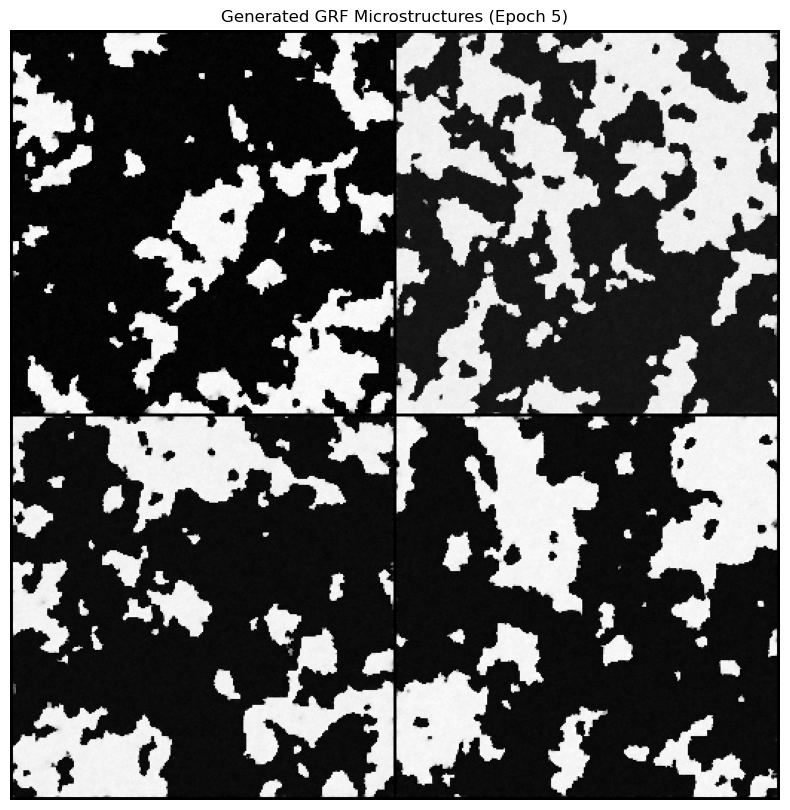

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0518]


Epoch 6/30, Loss: 0.016262


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.00609]


Epoch 7/30, Loss: 0.018259


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.00779]


Epoch 8/30, Loss: 0.015074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.00668]


Epoch 9/30, Loss: 0.013786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.00677]


Epoch 10/30, Loss: 0.013751


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:49<00:00,  9.09it/s]


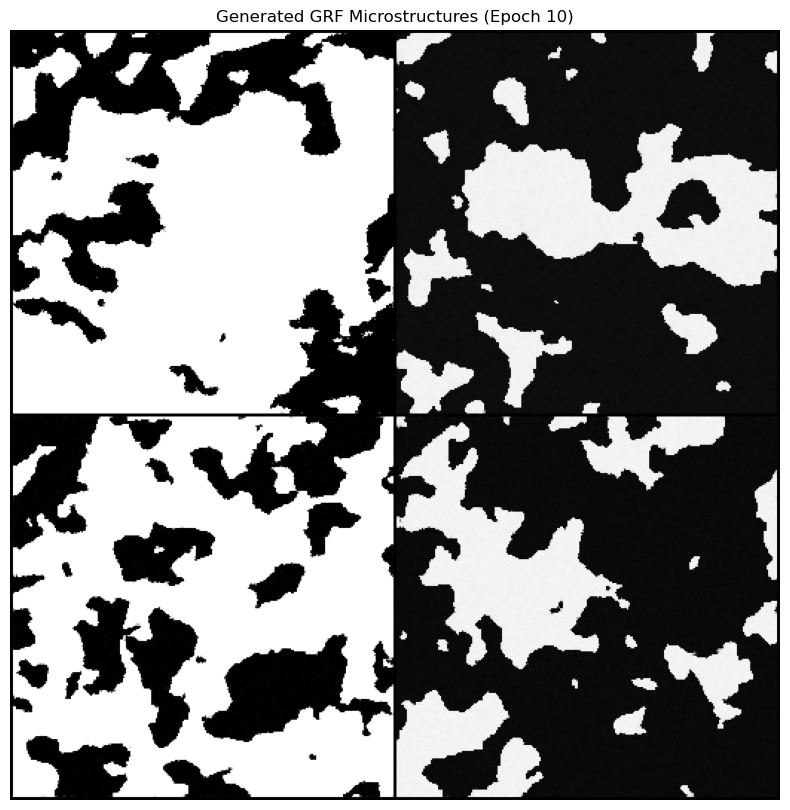

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.0133]


Epoch 11/30, Loss: 0.011687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:08<00:00,  2.06it/s, loss=0.00929]


Epoch 12/30, Loss: 0.010883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.0106]


Epoch 13/30, Loss: 0.010552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.00874]


Epoch 14/30, Loss: 0.010369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.0195]


Epoch 15/30, Loss: 0.009480


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:50<00:00,  9.03it/s]


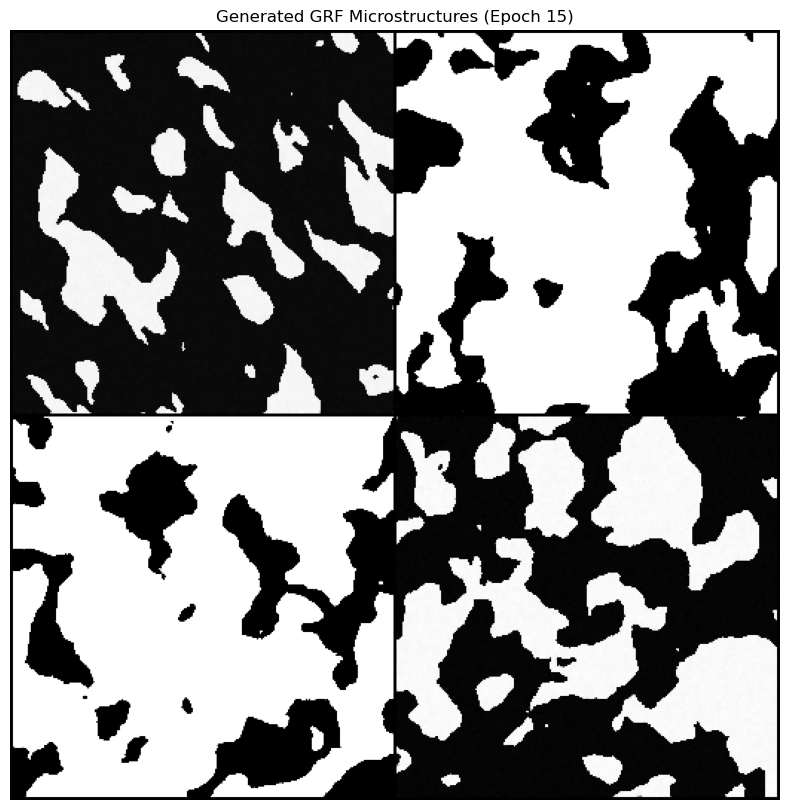

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.00839]


Epoch 16/30, Loss: 0.010001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.0136]


Epoch 17/30, Loss: 0.009179


100%|████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.0136]


Epoch 18/30, Loss: 0.008748


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.00383]


Epoch 19/30, Loss: 0.009109


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.00412]


Epoch 20/30, Loss: 0.008509


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:50<00:00,  9.03it/s]


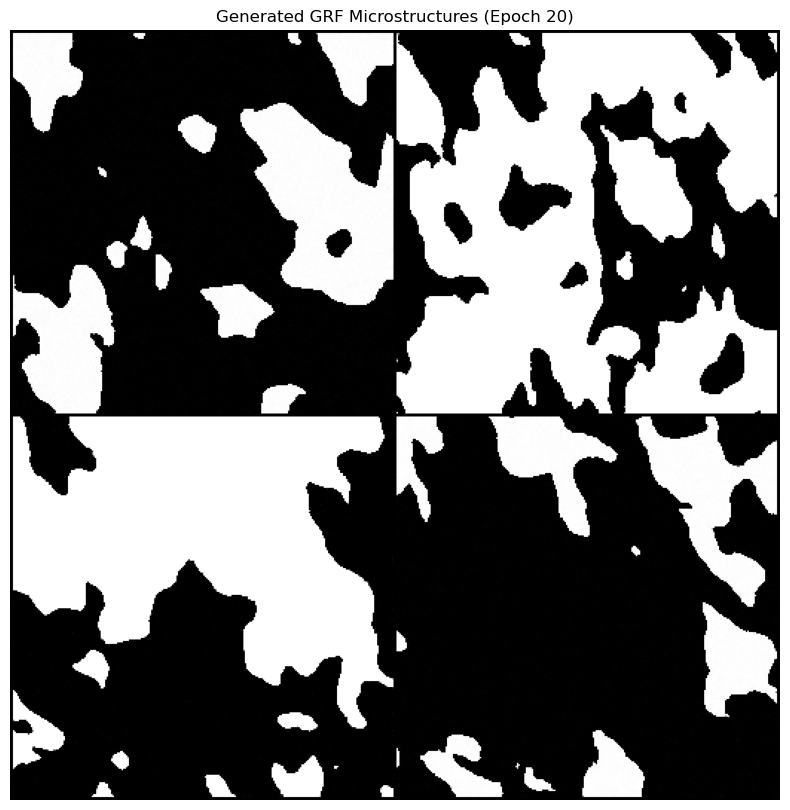

100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:08<00:00,  2.06it/s, loss=0.00529]


Epoch 21/30, Loss: 0.008989


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.00813]


Epoch 22/30, Loss: 0.007947


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.00724]


Epoch 23/30, Loss: 0.007843


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:08<00:00,  2.06it/s, loss=0.00336]


Epoch 24/30, Loss: 0.007782


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:08<00:00,  2.06it/s, loss=0.00781]


Epoch 25/30, Loss: 0.007627


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:49<00:00,  9.08it/s]


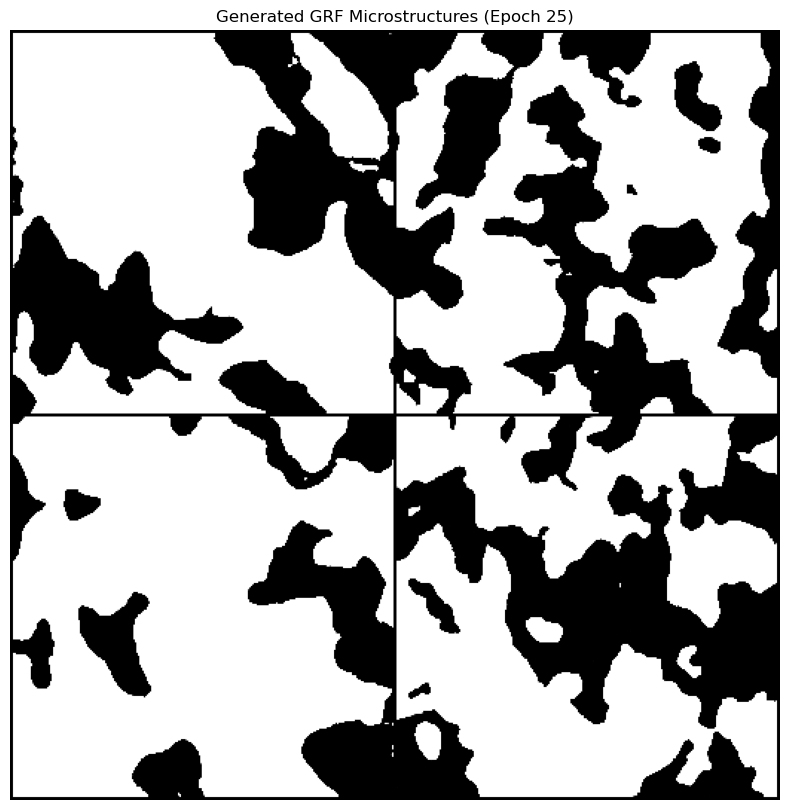

100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:08<00:00,  2.05it/s, loss=0.00831]


Epoch 26/30, Loss: 0.007346


100%|████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0124]


Epoch 27/30, Loss: 0.007315


100%|████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0104]


Epoch 28/30, Loss: 0.008329


100%|███████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:07<00:00,  2.06it/s, loss=0.00486]


Epoch 29/30, Loss: 0.007220


100%|████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [10:06<00:00,  2.06it/s, loss=0.0173]


Epoch 30/30, Loss: 0.007577


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:51<00:00,  8.99it/s]


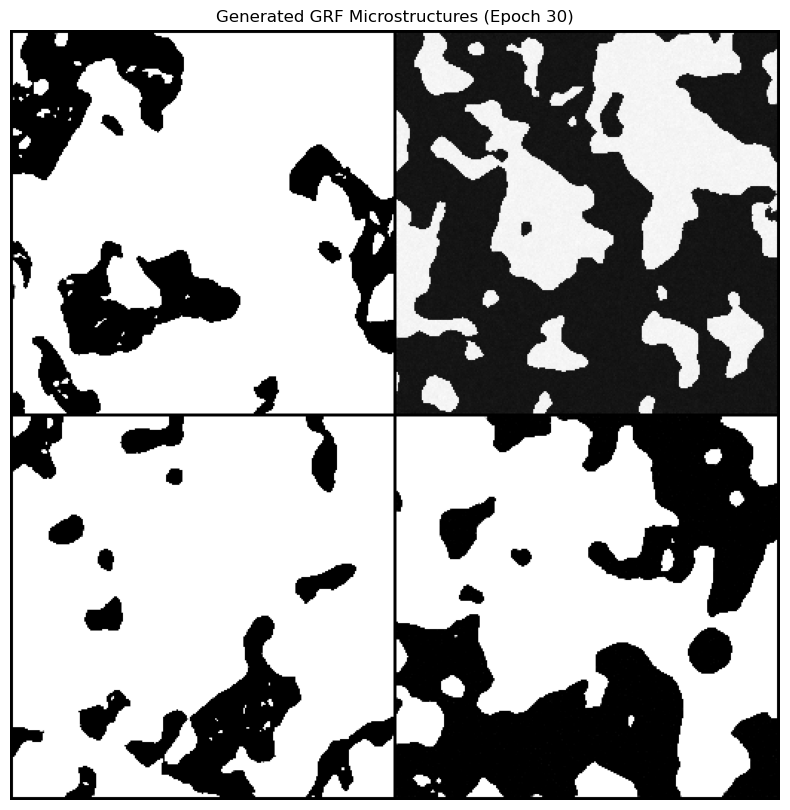

Training complete!


In [10]:
if __name__ == "__main__":
    main()

Using device: cuda


/tmp/ipykernel_27424/1056504161.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Generating samples...
Generating batch 1/7: 8 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:11<00:00,  5.22it/s]


Generating batch 2/7: 8 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:12<00:00,  5.20it/s]


Generating batch 3/7: 8 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:12<00:00,  5.20it/s]


Generating batch 4/7: 8 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:12<00:00,  5.20it/s]


Generating batch 5/7: 8 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:11<00:00,  5.20it/s]


Generating batch 6/7: 8 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:12<00:00,  5.20it/s]


Generating batch 7/7: 2 samples


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:10<00:00, 14.26it/s]


Collected 50 real samples and 50 generated samples
Extracting features...
Calculating FID...
Calculating IS...
FID Score: 0.0553 (lower is better)
Inception Score: 1.0000 ± 0.0000 (higher is better)
Visualizing samples...


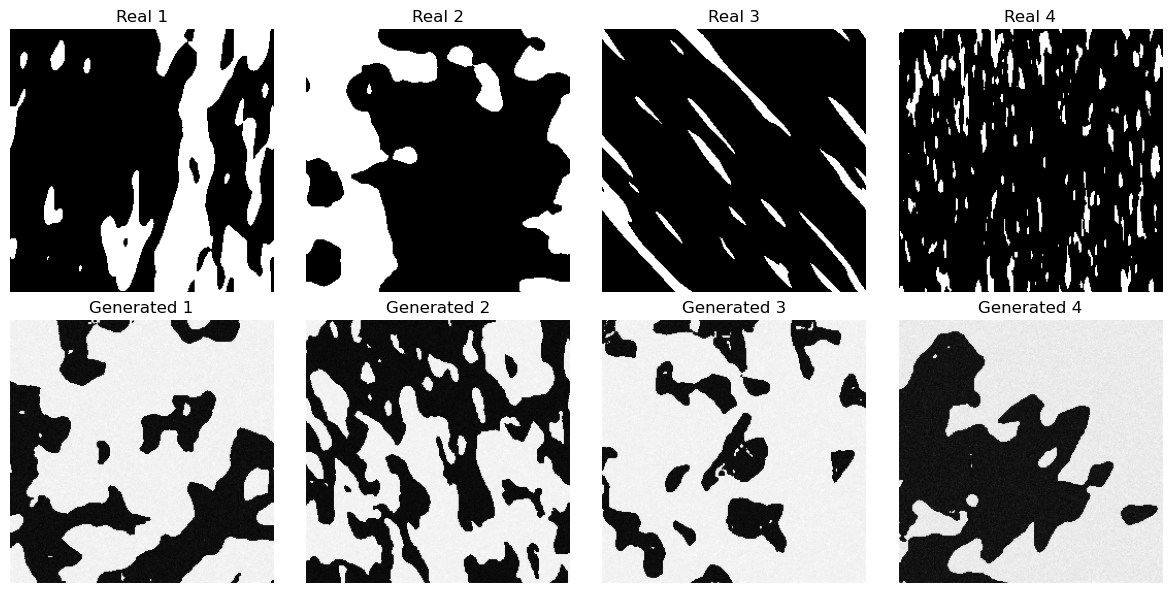

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class_name = "GRF"
batch_size = 8
image_size = 256
n_samples = 50  # Number of samples to use for evaluation

# Feature extractor for FID and IS calculation
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(256, 10)  # 10 classes for IS calculation
        
    def extract_features(self, x):
        x = self.features(x)
        return x.reshape(x.size(0), -1)
        
    def forward(self, x):
        features = self.extract_features(x)
        return self.classifier(features)

# Covariance matrix calculation for FID
def calculate_covariance(features):
    features_centered = features - features.mean(dim=0, keepdim=True)
    return (features_centered.T @ features_centered) / (features.size(0) - 1)

# Calculate FID score
def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance for both distributions
    mu1 = real_features.mean(dim=0)
    sigma1 = calculate_covariance(real_features)
    
    mu2 = fake_features.mean(dim=0)
    sigma2 = calculate_covariance(fake_features)
    
    # Convert to numpy for scipy operations
    mu1_np = mu1.cpu().numpy()
    sigma1_np = sigma1.cpu().numpy()
    mu2_np = mu2.cpu().numpy()
    sigma2_np = sigma2.cpu().numpy()
    
    # Calculate the squared difference between means
    diff = mu1_np - mu2_np
    mean_diff_squared = np.sum(diff * diff)
    
    # Calculate the square root of product of covariances
    covmean_matrix = sigma1_np @ sigma2_np
    covmean = linalg.sqrtm(covmean_matrix)
    
    # Numerical stability check
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate trace
    trace_term = np.trace(sigma1_np) + np.trace(sigma2_np) - 2 * np.trace(covmean)
    
    # FID = mean_diff_squared + trace_term
    fid = mean_diff_squared + trace_term
    
    return fid

# Calculate Inception Score
def calculate_inception_score(probs, n_split=10, eps=1e-16):
    N = probs.size(0)
    
    if N < n_split:
        n_split = N
    
    # Split into n_split groups
    split_scores = []
    for k in range(n_split):
        # Get a random subset of the data
        part = probs[k * (N // n_split): (k + 1) * (N // n_split), :]
        
        # Calculate KL divergence
        py = part.mean(dim=0, keepdim=True)
        scores = []
        for i in range(part.size(0)):
            p_i = part[i:i+1]
            kl = p_i * (torch.log(p_i + eps) - torch.log(py + eps))
            kl = kl.sum(dim=1)
            scores.append(kl)
        
        # Calculate exp of average KL
        split_scores.append(torch.exp(torch.stack(scores).mean()).item())
    
    # Return mean and standard deviation of scores
    return np.mean(split_scores), np.std(split_scores)

# Generate samples using the diffusion model
def generate_samples(model, diffusion, n_samples, batch_size=8):
    samples = []
    model.eval()
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            current_batch = min(batch_size, n_samples-i)
            print(f"Generating batch {i//batch_size + 1}/{(n_samples+batch_size-1)//batch_size}: {current_batch} samples")
            batch_samples = diffusion.sample(model, n=current_batch)
            samples.append(batch_samples)
    
    return torch.cat(samples, dim=0)

# Visualize samples
def visualize_samples(real_samples, fake_samples, n_samples=4):
    # Set up the figure
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))
    
    # Convert tensors to numpy arrays
    real_np = real_samples[:n_samples].cpu().detach().numpy().squeeze()
    fake_np = fake_samples[:n_samples].cpu().detach().numpy().squeeze()
    
    # Ensure arrays are in the right range for display
    real_np = (real_np + 1) / 2  # Convert from [-1, 1] to [0, 1]
    fake_np = (fake_np + 1) / 2  # Convert from [-1, 1] to [0, 1]
    
    # Display real samples
    for i in range(n_samples):
        axes[0, i].imshow(real_np[i], cmap='gray')
        axes[0, i].set_title(f"Real {i+1}")
        axes[0, i].axis('off')
    
    # Display fake samples
    for i in range(n_samples):
        axes[1, i].imshow(fake_np[i], cmap='gray')
        axes[1, i].set_title(f"Generated {i+1}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to evaluate the model
def evaluate_model():
    # Load the checkpoint
    checkpoint_path = "/lustre/uschill-lab/users/3782/Diff/checkpoints/ddpm_GRF_epoch30.pt"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Recreate model and load weights
    model = UNet().to(device)
    model.load_state_dict(checkpoint["ema_model"])  # Use EMA model for better results
    
    # Create diffusion process
    diffusion = Diffusion(img_size=image_size)
    
    # Load dataset
    dataset = MICRO2DDataset(
        file_path="./MICRO2D_homogenized.h5",
        class_name=class_name
    )
    
    # Set up dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize feature extractor
    feature_extractor = FeatureExtractor(in_channels=1).to(device)
    
    # Generate fake samples
    print("Generating samples...")
    fake_samples = generate_samples(model, diffusion, n_samples, batch_size)
    
    # Get real samples
    real_samples = []
    for i, batch in enumerate(dataloader):
        real_samples.append(batch.to(device))
        if len(real_samples) * batch_size >= n_samples:
            break
    real_samples = torch.cat(real_samples, dim=0)[:n_samples]
    
    print(f"Collected {len(real_samples)} real samples and {len(fake_samples)} generated samples")
    
    # Extract features and probabilities
    print("Extracting features...")
    real_features = []
    fake_features = []
    fake_probs = []
    
    with torch.no_grad():
        # Process in batches
        for i in range(0, n_samples, batch_size):
            r_batch = real_samples[i:i+batch_size]
            f_batch = fake_samples[i:i+batch_size]
            
            r_feat = feature_extractor.extract_features(r_batch)
            f_feat = feature_extractor.extract_features(f_batch)
            
            real_features.append(r_feat)
            fake_features.append(f_feat)
            
            # Get probabilities for IS
            f_prob = F.softmax(feature_extractor(f_batch), dim=1)
            fake_probs.append(f_prob)
    
    real_features = torch.cat(real_features, dim=0)
    fake_features = torch.cat(fake_features, dim=0)
    fake_probs = torch.cat(fake_probs, dim=0)
    
    # Calculate FID
    print("Calculating FID...")
    fid_score = calculate_fid(real_features, fake_features)
    
    # Calculate IS
    print("Calculating IS...")
    is_mean, is_std = calculate_inception_score(fake_probs)
    
    # Print results
    print(f"FID Score: {fid_score:.4f} (lower is better)")
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f} (higher is better)")
    
    # Visualize samples
    print("Visualizing samples...")
    visualize_samples(real_samples, fake_samples, n_samples=4)
    
    return {
        'fid': fid_score,
        'is_mean': is_mean,
        'is_std': is_std,
        'real_samples': real_samples[:4],
        'fake_samples': fake_samples[:4]
    }

# Run the evaluation
if __name__ == "__main__":
    evaluate_model()